## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import snntorch as snn
import snntorch.functional as SF
from snntorch import spikeplot as splt
import snntorch.spikegen as spikegen
import torch
from torch import nn
from torch.optim import Adam

## Model definitions

In [2]:
# Define the encoding layer for visual and auditory inputs
class EncodingLayer(nn.Module):
    def __init__(self, input_size, hidden_size, beta):
        super(EncodingLayer, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)
        self.lif = snn.Leaky(beta=beta)

    def forward(self, x):
        cur = self.fc(x)
        spk, mem = self.lif(cur)
        return spk, mem

In [3]:
class MultimodalIntegration(nn.Module):
    """
    Combine the outputs from the visual and auditory encoders into a single multimodal representation.
    """
    def __init__(self, multimodal_size, output_size, beta):
        super(MultimodalIntegration, self).__init__()
        self.fc = nn.Linear(multimodal_size, output_size)
        self.lif = snn.Leaky(beta=beta)

    def forward(self, x):
        cur = self.fc(x)
        spk, mem = self.lif(cur)
        return spk, mem

## Hyperparameters

## Create models

In [4]:
visual_size = 5  # Length of visual input vector
audio_size = 3   # Length of audio input vector
hidden_size = 10  # Number of neurons in the hidden layers
beta = 0.9  # Decay rate of the LIF neuron
multimodal_size = hidden_size * 2  # Combined size for multimodal layer

# Output size for the final multimodal representation
output_size = 4

In [5]:
# Create the encoding layers
visual_encoder = EncodingLayer(visual_size, hidden_size, beta)
audio_encoder = EncodingLayer(audio_size, hidden_size, beta)

In [6]:
net = MultimodalIntegration(multimodal_size, output_size, beta)

## Run stuff through them (no training)

In [7]:
# Create example input data
visual_input = torch.rand((visual_size,))
audio_input = torch.rand((audio_size,))

# Generate spike trains from input data
visual_spike_train = spikegen.rate(visual_input, num_steps=100)
audio_spike_train = spikegen.rate(audio_input, num_steps=100)

# Forward pass through the encoding layers
visual_spk, mem = visual_encoder(visual_spike_train.float())
audio_spk, mem = audio_encoder(audio_spike_train.float())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [8]:
# Concatenate the encoded spikes
combined_spikes = torch.cat((visual_spk, audio_spk), dim=1)
print(combined_spikes.shape)

# Forward pass through the integration layer
multimodal_output, mem = net(combined_spikes)
print(multimodal_output.shape)

#print("Multimodal output spike vector:", multimodal_output)

torch.Size([100, 20])
torch.Size([100, 4])


## Training

In [9]:
# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = Adam(net.parameters(), lr=0.01)

# Generate dummy training data
num_samples = 1000
inputs1 = torch.rand((num_samples, hidden_size))
inputs2 = torch.rand((num_samples, hidden_size))
targets = torch.rand((num_samples, output_size))

In [10]:
# Training loop
num_epochs = 2
num_steps = 100  # Number of timesteps for the spike train
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(num_samples):
        input_vector1 = inputs1[i]
        input_vector2 = inputs2[i]
        target = targets[i]

        # Concatenate input vectors
        input_vector = torch.cat((input_vector1, input_vector2))

        # Generate spike trains from input data
        spike_train = spikegen.rate(input_vector, num_steps=num_steps)

        # Initialize hidden states
        mem1 = net.lif.init_leaky()

        # Accumulate loss over timesteps
        total_loss = 0.0
        optimizer.zero_grad()
        for t in range(num_steps):
            # Forward pass through the network for each timestep
            cur1 = net.fc(spike_train[t])
            spk1, mem1 = net.lif(cur1, mem1)

            # Compute loss for this timestep
            loss = loss_fn(spk1, target)
            total_loss += loss

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    avg_loss = epoch_loss / num_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

        
print("Training complete")

Epoch 1/2, Loss: 33.2993
Epoch 2/2, Loss: 33.1589
Training complete


## Inference

In [13]:
# Create example input data
visual_input = torch.rand((visual_size,))
audio_input = torch.rand((audio_size,))

# Generate spike trains from input data
visual_spike_train = spikegen.rate(visual_input, num_steps=100)
audio_spike_train = spikegen.rate(audio_input, num_steps=100)

# Forward pass through the encoding layers
visual_spk, memv = visual_encoder(visual_spike_train.float())
audio_spk, mema = audio_encoder(audio_spike_train.float())

# Concatenate the encoded spikes
combined_spikes = torch.cat((visual_spk, audio_spk), dim=1)

# Forward pass through the integration layer
multimodal_output, mem = net(combined_spikes)

Vision Input: shape=torch.Size([100, 5]), spikes=319.0
Audio: shape=torch.Size([100, 10]), spikes=78.0
Multimodal: shape=torch.Size([100, 4]), spikes=0.0


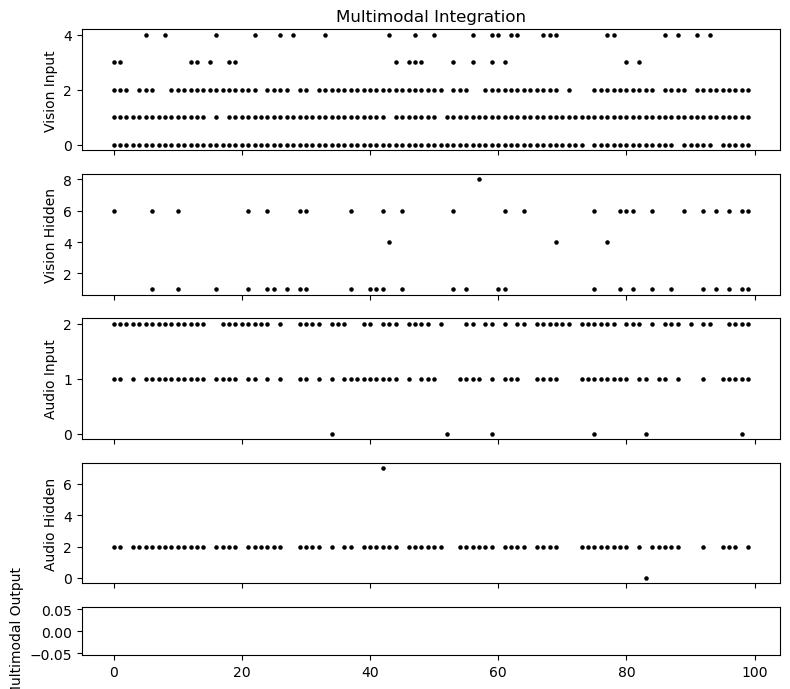

In [14]:
print(f"Vision Input: shape={visual_spike_train.shape}, spikes={visual_spike_train.sum()}")
print(f"Audio: shape={audio_spk.shape}, spikes={audio_spk.sum()}")
print(f"Multimodal: shape={multimodal_output.shape}, spikes={multimodal_output.sum()}")

fig, ax = plt.subplots(5, figsize=(8,7), sharex=True, 
                    gridspec_kw = {'height_ratios': [1, 1, 1, 1, 0.4]})

# Plot input spikes
splt.raster(visual_spike_train, ax[0], s=5, c="black")
ax[0].set_ylabel("Vision Input")
ax[0].set_title("Multimodal Integration")

# Plot hidden layer spikes
splt.raster(visual_spk, ax[1], s=5, c="black")
ax[1].set_ylabel("Vision Hidden")

# Plot input spikes
splt.raster(audio_spike_train, ax[2], s=5, c="black")
ax[2].set_ylabel("Audio Input")

# Plot hidden layer spikes
splt.raster(audio_spk, ax[3], s=5, c="black")
ax[3].set_ylabel("Audio Hidden")

# Plot output spikes
splt.raster(multimodal_output.reshape(num_steps, -1), ax[4], c="black", marker="|")
ax[4].set_ylabel("Multimodal Output")

plt.tight_layout()
plt.show()

## Can also plot mem; will show for each neuron
#plt.plot(memv.detach().numpy())
#plt.plot(mem.detach().numpy())